## What crimes category is increasing and what is decreasing in London?


In [1]:
import os
import numpy as np
import pandas as pd
from pandas.io import gbq
from sklearn import linear_model
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "deeplearning-97d854aac156.json"

# Instantiates a client
bigquery_client = bigquery.Client()


/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enzo/anaconda3/lib/python3.6/importlib/_bootstrap

### Gather

In [2]:
# Query for collecting data
QUERY ="""
SELECT major_category, year, sum(value) as number 
FROM  `bigquery-public-data.london_crime.crime_by_lsoa`
group by  major_category,year
order by  number DESC; 
"""

df = gbq.read_gbq(QUERY, dialect='standard' );

### Data Preparation
 
** Note: the dataset is clean, and no missing values or outliers are present.**


##### First, let's see the percentage of events for each category

In [3]:
criminal_summary = df.groupby('major_category').sum()['number']
criminal_summary

major_category
Burglary                        754293
Criminal Damage                 630938
Drugs                           470765
Fraud or Forgery                  5325
Other Notifiable Offences       106349
Robbery                         258873
Sexual Offences                   1273
Theft and Handling             2661861
Violence Against the Person    1558081
Name: number, dtype: int64

### Assess and Visualize

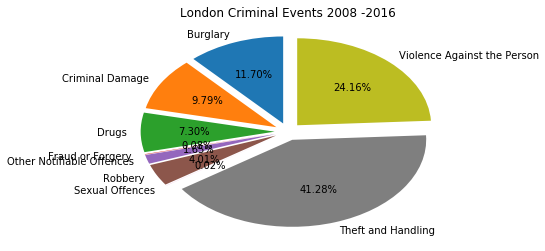

In [4]:
explode_sequence = ('0.1,' * len(criminal_summary)).split(',')
explode_sequence=[float(item) for item in explode_sequence if item !=""]

plt.pie(criminal_summary,explode=explode_sequence, labels=criminal_summary.index, autopct='%1.2f%%',
        shadow=False, startangle=90, );
plt.title("London Criminal Events 2008 -2016");

### The metric used to define whether the category crime is increasing or decreasing is the linear regression coefficient of number of crimes over the years.
If positive, is increasing.
If negative  is decreasing.

The absolute value of the coefficient defines the magnitude of the increase/decrease. 

To compare the linear coefficients for the different sets we need to standardize the data.
Otherwise, a category with major number of events would have different weight than a category with less events.

In [5]:
crimis = (set(df['major_category']))
cat_crime = dict()
min_reg=999
min_item=""
max_reg=0
max_item=""

for crim in crimis:
    temp=df[df['major_category'] == crim];
    X=temp[['year']];
    val_max = temp.number.max()
    val_min = temp.number.min()
    temp['number']=(temp.number-val_min)/(val_max-val_min);
    
    regr = linear_model.LinearRegression()
    regr.fit(X, temp.number.values)
    cat_crime[crim] = regr.coef_
    if regr.coef_ > max_reg:
        max_reg = regr.coef_
        max_item = crim
    if regr.coef_ < min_reg:
        min_reg = regr.coef_
        min_item = crim

print('coef max {}, for the crime "{}"'.format(max_reg, max_item))
print('coef min {}, for the crime "{}"'.format(min_reg, min_item))

/home/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


coef max [0.11300685], for the crime "Other Notifiable Offences"
coef min [-0.12133489], for the crime "Drugs"


### Evaluation 

In [6]:
mio_dataset=pd.DataFrame.from_dict(cat_crime, orient='index',columns=['coef_regr'])
mio_dataset.sort_values('coef_regr')

,coef_regr
Drugs,-0.121335
Burglary,-0.111029
Criminal Damage,-0.107906
Robbery,-0.087904
Fraud or Forgery,-0.066667
Sexual Offences,-0.066667
Theft and Handling,0.009270
Violence Against the Person,0.100199
Other Notifiable Offences,0.113007


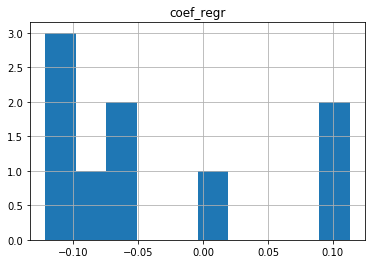

In [7]:
mio_dataset.hist();

Most of the coefficients are negative or close to zero.
Which is a good sign.
Let's have a look at the worst and the best.


### Just out of curiosity... let's find the crime category with most crimes decrease and the one with most crimes increase. 

In [10]:
def rescaling_function(temp):
    """
    The funcion is rescalling the dataset 'temp' and perform a linear regression.
    it returns a new dataset (the rescaled temp) and the predicted values
    for each year of the dataset. 
    """
    val_max = temp.number.max()
    val_min = temp.number.min()
    temp['number']=(temp.number-val_min)/(val_max-val_min)
    regr = linear_model.LinearRegression()
    regr.fit(temp[['year']], temp.number.values)
    y_Predict=regr.predict(temp[['year']])
    return temp, y_Predict

def graph_category(temp,trend_status,item,color):
    """
    The function receives in input the data-set for the crime category,
    the trend status (increasing or decreasing) ,the category name (item),
    and the colour that the plot need to be displayed.
    In output the function plot the related chart.
    """
    regr = linear_model.LinearRegression()
    regr.fit(temp[['year']], temp.number.values)
    y_Predict=regr.predict(temp[['year']])
    X=temp[['year']];
    plt.figure(figsize=(15, 6))
    plt.scatter(temp[['year']],temp.number.values,color=color)    
    plt.plot(temp[['year']],y_Predict,color=color)
    plt.xlabel('... Time ...')
    plt.ylabel("Crime per Year  ")
    plt.title('Trend for the most {} Category Crime "{}"'.format(trend_status,item));

/home/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


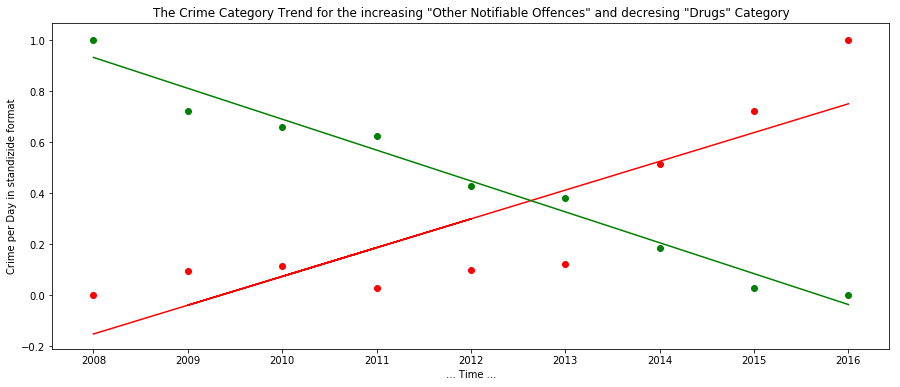

In [11]:
tempmax=df[df['major_category'] == max_item];
tempmax, y_maxPredict = rescaling_function(tempmax)

tempmin=df[df['major_category'] == min_item];
tempmin, y_minPredict = rescaling_function(tempmin)

X=tempmax[['year']];

plt.figure(figsize=(15, 6))
plt.scatter(tempmax[['year']],tempmax.number.values,color='red')    
plt.plot(tempmax[['year']],y_maxPredict,color='red')

plt.scatter(tempmin[['year']],tempmin.number.values, color='green')    
plt.plot(tempmin[['year']],y_minPredict,color='green')
plt.xlabel('... Time ...')
plt.ylabel("Crime per Day in standizide format")
plt.title('The Crime Category Trend for the increasing "{}" and decresing "{}" Category'.format(max_item,min_item));

#### The charts of the Crime category with most  decrease crimes (with the real value).

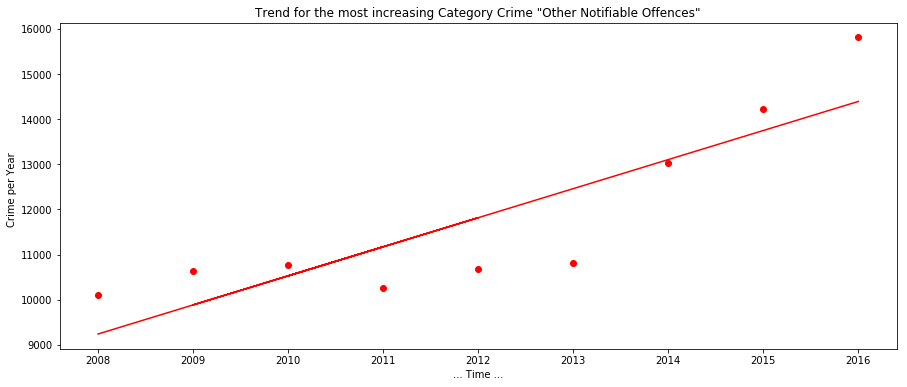

In [12]:
tempmax=df[df['major_category'] == max_item];

graph_category(temp=tempmax, trend_status='increasing',item=max_item,color='red')

#### The charts of the category crimes with most crimes decrease (with the real value).

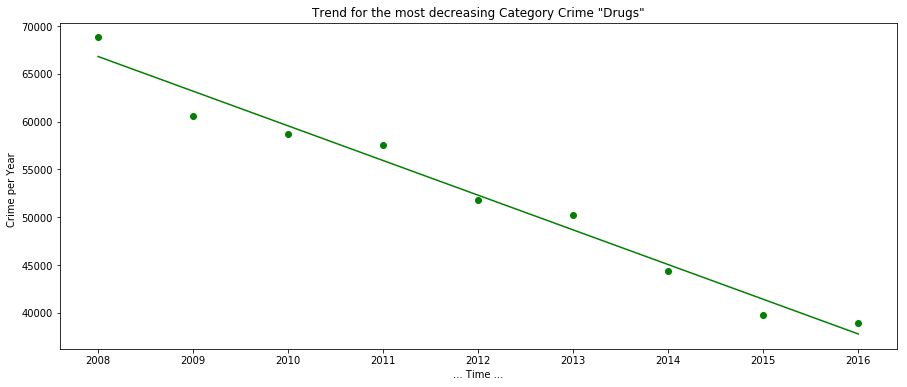

In [13]:
tempmin=df[df['major_category'] == min_item];
graph_category(temp=tempmin, trend_status='decreasing',item=min_item,color='green')

From the year 2008 to the year 2016 the number of crimes in Drugs category decreased of more of 25 thousands per year.

### Conclusion

Overall, the number of crimes in London is decreasing, there are only two categories of crimes where the number is increasing, which are "Violence Against the Person" and "Other Notifiable Offences".